In [1]:
# Idetifying latent return drivers using principal component analysis
import numpy as np
import pandas as pd
from openbb import obb
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
obb.user.preferences.output_type = "dataframe"
from sklearn.preprocessing import StandardScaler


In [ ]:
symbols = ['QBTS', 'QUBT', 'IONQ', 'MARA', 'CLSK', 'MSTR']

data = obb.equity.price.historical(
    symbols,
    start_date='2020-01-01',
    end_date='2022-12-31',
    provider='polygon'
).pivot(columns='symbol', values='close')
returns = data.pct_change().dropna()

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns)

pca = PCA(n_components=3)
pca.fit(returns_scaled)

In [ ]:
pct = pca.explained_variance_ratio_ # 每个主成分方差 / 总方差: 信息贡献比例
print(pct)
pca_components = pca.components_ # 各主成分在原空间的线性组合系数: 因子暴露
print(pca_components)

In [ ]:
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct) +1, 1)

plt.subplot(1, 2, 1)
plt.bar(x, pct*100, align='center')

plt.title("Contribution(%)")
plt.xticks(x) # set x axis label
plt.xlim([0,4])
plt.ylim([0,100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct*100, "ro-")

plt.title("Cumulative contribution(%)")
plt.xticks(x) # set x axis label
plt.xlim([0,4]) # limit for x and y
plt.ylim([0,100])


In [ ]:
X = np.array(returns)
factor_returns = X.dot(pca_components.T)
factor_returns = pd.DataFrame(
    columns=['f1', 'f2', 'f3'],
    index=returns.index,
    data=factor_returns
)
print(factor_returns)


In [ ]:
factor_exposures = pd.DataFrame(
    index=['f1', 'f2', 'f3'],
    columns=returns.columns,
    data=pca_components
).T
print(factor_exposures)

In [ ]:
labels = factor_exposures.index
data = factor_exposures.values
plt.scatter(data[:,0], data[:,1])
plt.xlabel("factor exposure for f1")
plt.ylabel("factor exposure for f2")
for label, x, y in zip(labels, data[:,0], data[:,1]):
    plt.annotate(
        label,
        xy=(x,y),
        xytext=(-20, 20),
        textcoords="offset points",
        arrowprops=dict(
            arrowstyle="->",
            connectionstyle="arc3, rad=0"
        )
    )
    

In [ ]:
# Finding and hedging portfolio beta using linear regression
import numpy as np
import pandas as pd
from openbb import obb
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
obb.user.preferences.output_type = "dataframe"


In [ ]:
symbols = ['NEM', 'RGLD', 'SSRM', 'CDE', 'LLY', 'UNH', 'JNJ', 'MRK', 'SPY']
data = obb.equity.price.historical(
    symbols,
    start_date='2020-01-01',
    end_date='2022-12-31',
    provider='polygon'
).pivot(columns='symbol', values='close')

In [ ]:
benchmark_returns = (
    data
    .pop('SPY')
    .pct_change()
    .dropna()
)
print(benchmark_returns)
portfolio_returns = (
    data
    .pct_change()
    .dropna()
    .sum(axis=1)
)
print(portfolio_returns)


In [ ]:
portfolio_returns.name = 'portfolio'

portfolio_returns.plot()
benchmark_returns.plot()
plt.ylabel('Daily Return')
plt.legend()

In [ ]:
X = benchmark_returns.values
Y = portfolio_returns.values
def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:,1]
    return model.params[0], model.params[1]


In [ ]:
alpha, beta = linreg(X, Y)
print(f'Alpha: {alpha}')
print(f'Beta: {beta}')



In [ ]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha
plt.scatter(X, Y, alpha=0.3)
plt.xlabel('SPY daily return')
plt.ylabel('Portfolio daily return')
plt.plot(X2, Y_hat, 'r', alpha=0.9)

In [ ]:
hedged_portfolio_returns = -1 * beta * benchmark_returns + portfolio_returns
p = hedged_portfolio_returns.values
_, beta = linreg(X, p)
print(f'Beta: {beta}')

In [ ]:
def information_ratio(
    portfolio_returns,
    benchmark_returns
):
    active_return = portfolio_returns - benchmark_returns
    tracking_error = active_return.std()
    return active_return.mean() / tracking_error

hedged_ir = information_ratio(
    hedged_portfolio_returns,
    benchmark_returns
) 


unhedged_ir = information_ratio(
    portfolio_returns,
    benchmark_returns
)

print(f'Hedged information ratio: {hedged_ir}')
print(f'Unhedged information ratio: {unhedged_ir}')

In [31]:
# Analyzing portfolio sensitivities to the Fama-French factors
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from openbb import obb
import statsmodels.api as sum
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
obb.user.preferences.output_type = 'dataframe'

In [33]:
symbols = ['NEM', 'RGLD', 'SSRM', 'CDE', 'LLY', 'UNH', 'JNJ', 'MRK', 'SPY']
data = obb.equity.price.historical(
    symbols,
    start_date='2015-01-01',
    end_date='2022-12-31',
    provider='yfinance'
).pivot(columns='symbol', values='close')

monthly_returns = (
    data
    .asfreq('ME')
    .dropna()
    .pct_change(fill_method=None)
    .to_period('M')
)
print(monthly_returns)

symbol        CDE       JNJ       LLY       MRK       NEM      RGLD       SPY  \
date                                                                            
2015-03       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2015-04  0.108280 -0.013917 -0.010736  0.036187  0.220175  0.022500  0.009834   
2015-06  0.093870 -0.017540  0.161681 -0.044157 -0.118158 -0.045560 -0.012520   
2015-07 -0.381786  0.028217  0.012217  0.035658 -0.264983 -0.181361  0.022589   
2015-08 -0.048159 -0.062169 -0.025559 -0.086669 -0.005824 -0.045617 -0.060950   
...           ...       ...       ...       ...       ...       ...       ...   
2022-06 -0.218509 -0.011252  0.034424 -0.009345 -0.120560 -0.055713 -0.086407   
2022-08 -0.092105 -0.091093 -0.070937 -0.063727 -0.306854 -0.139352  0.047528   
2022-09  0.239130  0.012520  0.073432  0.008903  0.016199  0.020892 -0.096159   
2022-10  0.105263  0.064949  0.119808  0.175104  0.006900  0.012151  0.081276   
2022-11 -0.074074  0.023165 

In [34]:
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = (R-bench).dropna()

In [35]:
factors = pdr.get_data_famafrench(
    'F-F_Research_Data_Factors',
    start='2015-01-01',
    end='2022-12-31'
)[0][1:] / 100 # [0] 取第一个数据集（主要的因子数据），[1:] 跳过第一行数据，通常第一行是列标题或说明信息， /100 除以100转换为小数形式（如 0.052）
SMB = factors.loc[active.index, 'SMB']
HML = factors.loc[active.index, 'HML']

/tmp/ipykernel_3905/2906909493.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.get_data_famafrench(
/tmp/ipykernel_3905/2906909493.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.get_data_famafrench(


In [36]:
df = pd.DataFrame(
    {
        'R': active,
        'SMB': SMB,
        'HML': HML,
    },
    index=active.index
).dropna()

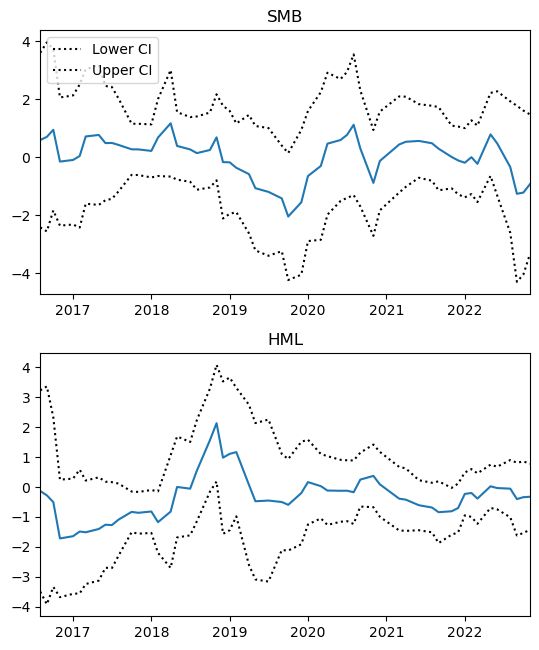

In [ ]:
# exogenous 外向性/自变量
exog = sm.add_constant(df[['SMB', 'HML']])
# yt​=α+β1​x1,t​+β2​x2,t​+εt​ (rolling window=12)
rols = RollingOLS(active, exog, window=12)
rres = rols.fit() # RollingRegressionResults
# | Date    | const | SMB  | HML   |
# | ------- | ----- | ---- | ----- |
# | 2015-12 | 0.001 | 0.32 | -0.15 |
# | 2016-01 | 0.002 | 0.30 | -0.12 |
# | ...     | ...   | ...  | ...   |
fig = rres.plot_recursive_coefficient(
    variables = ['SMB', 'HML'],
    figsize = (5.5, 6.6)
)
# CI in the plot stands for Confidence Intervals

In [ ]:
# Marginal Contribution to Active Risk(MCAR)
# 静态因子回归
# Rt=βSMB⋅SMBt+βHML⋅HMLt+ϵt
# b1 = βSMB, b2 = βHML
b1, b2 = regression.linear_model.OLS(
    df.R,
    df[['SMB', 'HML']]
).fit().params

F1 = df.SMB
F2 = df.HML
cov = np.cov(F1, F2)
ar_squared= (active.std()) ** 2
mcar1 = (b1 * (b2 * cov[0,1] + b1 * cov[0,0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0,1] + b2 * cov[1,1])) / ar_squared
print(f'SMB risk contribution: {mcar1}')
print(f'HML risk contribution: {mcar2}')
print(f'Unexplained risk contribution:{1-(mcar1+mcar2)}')



SMB risk contribution: 0.0021921641015125574
HML risk contribution: 0.007924093857188558
Unexplained risk contribution:0.9898837420412989


In [39]:
covariances = (
    df[['SMB', 'HML']]
    .rolling(window=12)
    .cov()
).dropna()

active_risk_squared = (
    active.rolling(window=12).std() ** 2
).dropna()

betas = pd.concat(
    [rres.params.SMB, rres.params.HML],
    axis=1
).dropna()

MCAR = pd.DataFrame(
    index=betas.index,
    columns=betas.columns
)

for factor in betas.columns:
    for t in betas.index:
        s = np.sum(betas.loc[t] * covariances.loc[t][factor])
        b = betas.loc[t, factor]
        AR = active_risk_squared.loc[t]
        MCAR.loc[t, factor] = b * s / AR
        


<Figure size 1200x600 with 0 Axes>

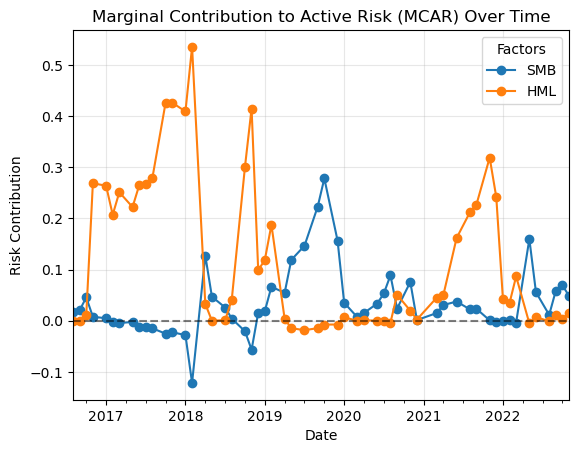

In [40]:
# 时间序列图
plt.figure(figsize=(12, 6))
MCAR.plot(kind='line', marker='o')
plt.title('Marginal Contribution to Active Risk (MCAR) Over Time')
plt.xlabel('Date')
plt.ylabel('Risk Contribution')
plt.legend(title='Factors')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.show()